<a href="https://colab.research.google.com/github/durml91/State-Space-Models/blob/main/S4_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


S4 exploration
---
Taken from https://srush.github.io/annotated-s4/. Alternative approach to attention-only models (see Mamba next). Big problem with attention is quadratic scaling with longer and longer context windows (hence solutions such as sliding window attention). Key ideas involves long range sequence modelling, continuous vs. discrete (think neural ODEs) and CNN at training to RNN at inference (convolution is an operation that mixes information across vectors, analagous to attention).



In [13]:
# !pip install celluloid

In [83]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve
import numpy as np
import numpy.polynomial.legendre

import matplotlib.pyplot as plt
import seaborn
from celluloid import Camera

In [47]:
rng = jr.PRNGKey(2024)

State space model: $x'(t) = \boldsymbol{A} x(t) + \boldsymbol{B} u(t)$ and $y(t) = \boldsymbol{C} x(t) + \boldsymbol{D} u(t)$. This is an ODE w.r.t. time whereby the input is actually $u(t)$ in 1D, $x(t)$ is multi-dimensional and the output "signal" $y(t)$ is 1D. The parameters/matrices in bold are learnt, although the authors adopt the convention $\boldsymbol{D}=0$ as this bit is actually just a skip connection.

In [56]:
#initiliase random matrices

def random_SSM(N, key):
  a_key, b_key, c_key = jr.split(key, 3)

  A = jr.uniform(key=a_key, shape=(N,N))
  B = jr.uniform(key=b_key, shape=(N,1))
  C = jr.uniform(key=c_key, shape=(1,N))

  return A,B,C

Discretise input sequence $u(t) \to (u_{0}, u_{1},...)$. So we are basically sampling from the underlying signal every step of size $\Delta$ such that $u_{i} = u(i \cdot \Delta)$. The authors use the bilinear method from control theory (continuous time in Laplace domain to discrete time in complex plane) to approximate the parameters: $\bar{\boldsymbol{A}} = (\boldsymbol{I} - \frac{\Delta}{2} \cdot \boldsymbol{A})^{-1}(\boldsymbol{I} + \frac{\Delta}{2} \cdot \boldsymbol{A})$, $\bar{\boldsymbol{B}} = (\boldsymbol{I} - \frac{\Delta}{2} \cdot \boldsymbol{A})^{-1} \Delta \boldsymbol{B}$ and $\bar{\boldsymbol{C}}= \boldsymbol{C}$. This discretisation (analagous to the Euler discretisation) allows us to write the ODE as a recurrence relation, namely $x_k = \bar{\boldsymbol{A}}x_{k-1} + \bar{\boldsymbol{B}}u_k$. Given $\boldsymbol{D} = 0$ (sort of), this also gives us a nice closed form solution for y, namely $y_k = \bar{\boldsymbol{C}} (\bar{\boldsymbol{A}}x_{k-1} + \bar{\boldsymbol{B}}u_k)$. This looks like an RNN layer.

In [6]:
# compute bilinear transformation #

# simply computes A_bar and B_bar
def discretise(A, B, C, step):
  I = jnp.eye(A.shape[0]) # returns diagonal matrix with 1s for identity
  bl = jnp.linalg.inv(I - (step / 2.) * A) # bilinear bit
  A_bl = bl @ (I + (step / 2.) * A) # could use einops.einsum
  B_bl = (bl * step) @ B

  return A_bl, B_bl, C

def scan_SSM(A_bl, B_bl, C_bl, u, x0):

  # recursive function that computes next state
  def step(x_k_1, u_k):
    x_k = A_bl @ x_k_1 + B_bl @ u_k
    y_k = C_bl @ x_k
    return x_k, y_k

  #recurse  here
  return jax.lax.scan(step, x0, u) # apply step with x0 as carry and u as invariant

def run_SSM(A, B, C, u):
  L= u.shape[0]
  N = A.shape[0]
  A_bl, B_bl, C_bl = discretise(A, B, C, step=1./L)

  return scan_SSM(A_bl, B_bl, C_bl, jnp.expand_dims(u, axis=-1), jnp.zeros((N,)))[1] # initial state here is vector of zeroes

Interlude: **mechanics example** - spring on wall with mass attached. $y(t)$ is the position of a mass attached to wall with spring and $u(t)$ is force applied to mass. Mass is $m$, spring constant $k$ and friction coefficient is $\mu$. $F=ma$ gives us the following second order ODE: $my''(t) = u(t) - \mu y'(t) - ky(t)$. The key is to use linear algebra (ofc) to write this in matrix form: $ \boldsymbol{A} = \left[ {\begin{array}{ccccc}
    0 & 1 \\
    -\frac{\mu}{m} & -\frac{b}{m} \\
  \end{array}} \right]$, $\boldsymbol{B} = \left[ {\begin{array}{ccccc}
    0 \\
    \frac{1}{m}\\
  \end{array}} \right]$, $\boldsymbol{C} = [1 \ \ 0]$. Thinking about $x(t)$ as the hidden/latent state ($h(t)$ from RNNs), first dim is position and second dim is velocity (look back at SSM system of equations and observe that hidden state equals output $y(t)$ as $\boldsymbol{D}$ will be zero and the force on the mass only affects the velocity).

In [15]:
# create systems of lin eqs
def example_mass(k, b, mu):
  A = np.array([[0, 1], [-k/mu, -b/mu]])
  B = np.array([[0], [1./mu]])
  C = np.array([[1., 0]])

  return A, B, C

# could use jax.vmap

@partial(np.vectorize, signature="()->()")
def example_force(t):
  x = np.sin(10*t)
  return x * (x>0.5) # only values over 0.5

In [33]:
def example_ssm():
  # SSM
  ssm = example_mass(k=40, b=5, mu=1)

  # L samples of the force u(t)
  L = 100 #dim of force u(t)
  step = 1./L
  ks = np.arange(L) # step is already 1
  u = example_force(ks*step)

  # approximation of y(t) - feels like Euler method, with SSM added in
  y = run_SSM(*ssm, u)

  # plots
  seaborn.set_context("paper")
  fig, (ax1, ax2, ax3) = plt.subplots(3)
  camera = Camera(fig)
  ax1.set_title("Force $u_k$")
  ax2.set_title("Position $y_k$")
  ax3.set_title("Object")
  ax1.set_xticks([], [])
  ax2.set_xticks([], [])

  # live plotting
  for k in range(0, L, 1):
    ax1.plot(ks[:k], u[:k], color="red")
    ax2.plot(ks[:k], y[:k], color="blue")
    ax3.boxplot(
        [[y[k, 0]  - 0.04, y[k, 0], y[k, 0] + 0.04]],
        showcaps = False,
        whis = False,
        vert = False,
        widths = 10,
    )
    camera.snap()

  anim = camera.animate()
  plt.show()

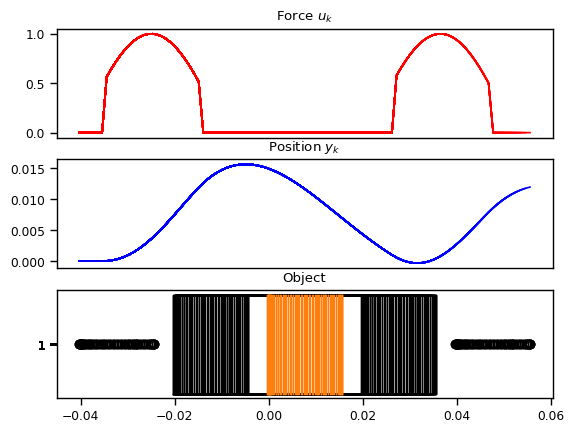

In [34]:
example_ssm()

We're doing sequence modelling; bit idea is that whilst inference will follow this RNN recursive loop, we can train more efficiently by exploiting convolutions (discrete ofc). Looking back at the two discretised s.o.l.e's above, starting at the initial state $x_{-1} = 0$ we can compute each timestep for both $x_k$ and $y_k$. For the $y_k$'s we notice this is a convolution w.r.t. $u$. Specifically, the kernel here is just $\bar{\boldsymbol{K}} = \bar{\boldsymbol{C}}\bar{\boldsymbol{A}}^p\bar{\boldsymbol{B}}u_q$ where $p+q = k : 0\leq p,q \leq k$. In closed form this looks like $y = \bar{\boldsymbol{K}} * u$. As the author notes, this filter is the length of the entire sequence therefore naively implementing it is no good!

In [60]:
# placeholder kernel

def K_conv(Ab, Bb, Cb, L):
  return np.array(
      [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
  )

Once we have the kernel, we wish to actually compute the convolution. We can apply the convolution theorem with FFT (reminds me of the characteristic function). Important corollary here: $\mathcal{F}^{-1}\{U \cdot V \}$ where $U, V$ are fourier transformed versions of functions $u, v$.

In [61]:
def causal_convolution(u, K, nofft=False):
  if nofft:
    return convolve(u, K, mode="full")[: u.shape[0]]
  else:
    assert K.shape[0] == u.shape[0]
    ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
    Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
    out = ud * Kd
    return np.fft.irfft(out)[: u.shape[0]]

We can compare the CNN and RNN (recursion) computations:

In [58]:
def test_cnn_is_rnn(N=4, L=16, step=1./16):
  ssm = random_SSM(N, rng)
  u = jr.uniform(rng, (L,))
  jr.split(rng, 3)

  # RNN
  rec = run_SSM(*ssm, u)

  # CNN
  ssm_b = discretise(*ssm, step=step)
  conv = causal_convolution(u, K_conv(*ssm_b, L))

  # check
  assert np.allclose(rec.ravel(), conv.ravel()) # ravel is equivalent to flatten()

In [63]:
try:
  test_cnn_is_rnn()
  print("works")
except:
  raise Exception("doesn't work")

works


**SSM x NN** - SSM above is a sequence map from $\mathbb{R}^L \to \mathbb{R}^L$ - vector to vector. The learnable parameters are $\boldsymbol{B}$, $\boldsymbol{C}$ ($\boldsymbol{A}$ is the HiPPO matrix), step-size $\Delta$ and scalar $D$.

In [72]:
# step size is learnt in log space
def log_step_initialiser(dt_min=0.001, dt_max=0.1):
  def init(shape, key):
    return jr.uniform(key, shape) * (
        np.log(dt_max) - np.log(dt_min)
    ) + np.log(dt_min)

  return init

In [77]:
class SSMLayer(nn.Module):
  N: int
  l_max: int
  decode: bool = False

  def setup(self):
    # SSM params
    self.A = self.param("A", lecun_normal(), (self.N, self.N))
    self.B = self.param("B", lecun_normal(), (self.N, 1))
    self.C = self.param("C", lecun_normal(), (1, self.N))
    self.D = self.param("D", nn.initializers.ones, (1, ))

    # step parameter
    self.log_step = self.param("log_step", log_step_initialiser(), (1, ))
    step = np.exp(self.log_step)
    self.ssm = discretise(self.A, self.B, self.C, step=step)
    self.K = K_conv(*self.ssm, self.l_max)

    # RNN cache - when using RNN, cache previous state
    self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N, ))

  def __call__(self, u):
    if not self.decode:
      # CNN
      return causal_convolution(u, self.K) + self.D * u
    else:
      # RNN
      x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
      if self.is_mutable_collection("cache"): # flax - returns True if cache is mutable
        self.x_k_1.value = x_k
      return y_s.reshape(-1).real + self.D * u

In [79]:
# vmap over H stacked SSMs for each scalar input
def cloneLayer(layer):
  return nn.vmap( # flax method
    layer,
    in_axes=1,
    out_axes=1,
    variable_axes={"params": 1, "cache": 1, "prime": 1},
    split_rngs={"params": True},
  )

In [80]:
SSMLayer = cloneLayer(SSMLayer)

In [ ]:
# integrate with standard NN

class SequenceBlock(nn.Module):
  layer_cls: nn.Module
  layer: dict # hyperparameters of inner layer
  dropout: float
  d_model: int
  prenorm: bool = True
  glu: bool = True
  training: bool = True
  decode: bool = False

  def setup(self):
    self.seq = self.layer_cls(**self.layer, decode=self.decode)
    self.norm = nn.LayerNorm()
    self.out = nn.Dense(self.d_model)
    if self.glu:
      self.out2 = nn.Dense(self.d_model)
    self.drop = nn.Dropout(
        self.dropout,
        broadcast_dims=[0],
        deterministic=not self.training,
    )

  def __call__(self, x):
    skip = x
    if self.prenorm:
      x = self.norm(x)
    x = self.seq(x)
    x = self.drop(nn.gelu(x))
    if self.glu:
      x = self.out(x) * jax.nn.sigmoid(self.out2(x))
    else:
      x = self.out(x)
    x = skip + self.drop(x)
    if not self.prenorm:
      x = self.norm(x)
    return x

In [81]:
# stack SSM blocks to create transformer-like model #

class Embedding(nn.Embed):
  num_embeddings: int
  features: int

  @nn.compact
  def __call__(self, x):
    y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
    return np.where(x > 0, y, 0.)

class StackedModel(nn.Module):
  layer_cls: nn.Module
  layer: dict # extra args for layer
  d_output: int
  d_model: int
  n_layers: int
  prenorm: bool = True
  dropout: float = 0.0
  embedding: bool = False
  classification: bool = False
  training: bool = True
  decode: bool = False

  def setup(self):
    if self.embedding:
      self.encoder = Embedding(self.d_output, self.d_model)
    else:
      self.encoder = nn.Dense(self.d_model)
    self.decoder = nn.Dense(self.d_output)
    self.layers = [
        SequenceBlock(
            layer_cls=self.layer_cls,
            layer=self.layer,
            prenorm=self.prenorm,
            d_model=self.d_model,
            dropout=self.dropout,
            training=self.training,
            decode=self.decode,
        )
        for _ in range(self.n_layers)
    ]

  def __call__(self, x):
    if not self.classification:
      if not self.embedding:
        x = x/255. # normalise
      if not self.decode:
        x = np.pad(x[:-1], [(1, 0), (0, 0)])
    x = self.encoder(x)
    for layer in self.layers:
      x = layer(x)
    if self.classification:
      x = np.mean(x, axis=0)
    x = self.decoder(x)
    return nn.log_softmax(x, axis=-1)

In [82]:
# RNN and parameter caching
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True}
)

HiPPO matrix: this is a set of square matrices that allow the hidden state $x(t)$ to memorise the history of the input $u(t)$. $ \boldsymbol{A}_{nk}  =
  \begin{cases}
      (2n+1)^{\frac{1}{2}}(2k+1)^{\frac{1}{2}} & \text{if} \ \ n > k \\
      n+1 & \text{if} \ \ n=k \\
      0 & \text{if} \ \ n<k \\
  \end{cases}$. \\
  This somehow computes the cofficients of a Legendre polynomial (orthogonal set of polynomials that form a basis - think space of polynomials).

In [ ]:
# calculate HiPPO matrix once

def make_HiPPO(N):
  P = np.sqrt(1 + 2 * np.arange(N))
  A = P[:, np.newaxis] * P[np.newaxis, :]
  A = np.tril(A) - np.diag(np.arange(N))
  return -A

In [91]:
def example_legendre(N=8):
  # random hidden state as coeffs
  x = (np.random.rand(N) - 0.5) * 2
  t = np.linspace(-1, 1, 100)
  f = numpy.polynomial.legendre.Legendre(x)(t)

  # plot
  seaborn.set_context("talk")
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(projection="3d")
  ax.plot(
      np.linspace(-25, (N-1) * 100 + 25, 100),
      [0] * 100,
      zs=-1,
      zdir="x",
      color="black",
  )
  ax.plot(t, f, zs=N*100, zdir="y", c="r")
  for i in range(N):
    coef = [0] * N
    coef[N-i-1] = 1
    ax.set_zlim(-4, 4)
    ax.set_yticks([])
    ax.set_zticks([])

    # plot basis function
    f = numpy.polynomial.legendre.Legendre(coef)(t)
    ax.bar(
        [100*i],
        [x[i]],
        zs=-1,
        zdir="x",
        label="x%d" % i,
        color="brown",
        fill=False,
        width=50,
    )
    ax.plot(t, f, zs=100*i, zdir="y", c="b", alpha=0.5)
  ax.view_init(elev=40., azim=-45)

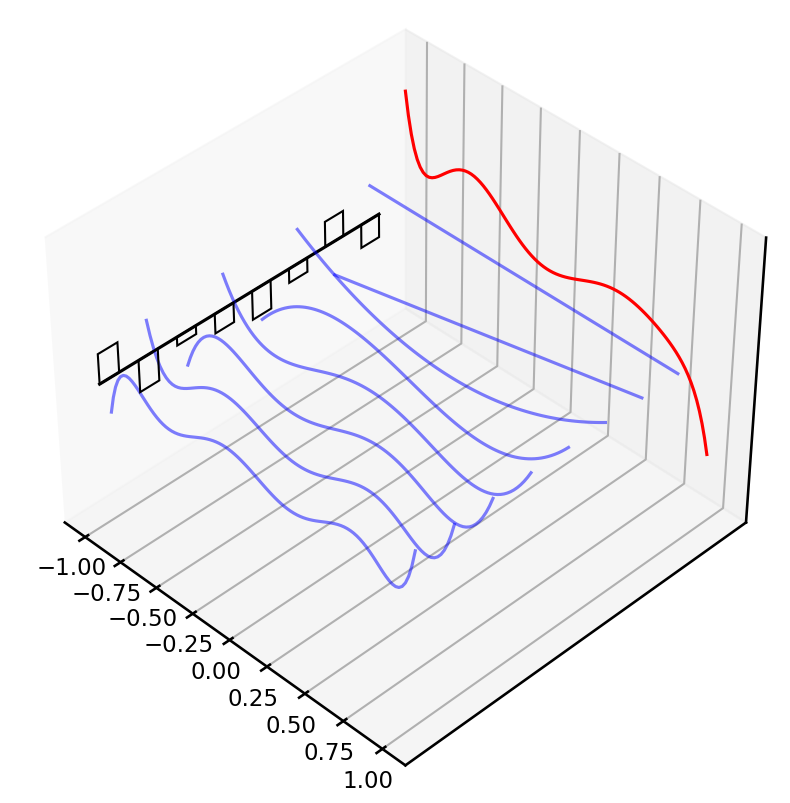

In [92]:
example_legendre()

How to compute HiPPO optimally? Also, SSMs require this matrix $\bar{\boldsymbol{A}}$ to be mutliplied up to L times (L recursions), so this would be $\mathcal{O}(N^2 L)$ operations (specifically in the convolution, this is done from 0 to L times).